In [4]:
import numpy as np
import pandas as pd
import sqlite3
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

cnx = sqlite3.connect('database.sqlite')

player_data = pd.read_sql("SELECT id, player_api_id, player_name, birthday, height, weight FROM Player", cnx)
player_stats_data = pd.read_sql("SELECT id, player_api_id, date, overall_rating, potential, preferred_foot, attacking_work_rate, defensive_work_rate, crossing, finishing, heading_accuracy, short_passing, volleys, dribbling, curve, free_kick_accuracy, long_passing, ball_control, acceleration, sprint_speed, agility, reactions, shot_power, jumping, stamina, strength, long_shots, aggression, interceptions, positioning, vision, penalties, marking, standing_tackle, sliding_tackle, gk_diving, gk_handling, gk_kicking, gk_positioning, gk_reflexes FROM Player_Attributes", cnx)
match_data = pd.read_sql("SELECT id, country_id, league_id, season, stage, date, match_api_id, home_team_api_id, away_team_api_id, home_team_goal, away_team_goal, home_player_1, home_player_2, home_player_3, home_player_4, home_player_5, home_player_6, home_player_7, home_player_8, home_player_9, home_player_10, home_player_11, away_player_1, away_player_2, away_player_3, away_player_4, away_player_5, away_player_6, away_player_7, away_player_8, away_player_9, away_player_10, away_player_11, goal, shoton, shotoff, foulcommit, card, cross, corner, possession, B365H, B365D, B365A FROM Match", cnx)
league_data = pd.read_sql("SELECT id, country_id, name FROM League", cnx)
country_data = pd.read_sql("SELECT id, name FROM Country", cnx)
team_data = pd.read_sql("SELECT id, team_api_id, team_long_name, team_short_name FROM Team", cnx)
team_attributes_data = pd.read_sql("SELECT id, team_api_id, date, buildUpPlaySpeed, buildUpPlaySpeedClass, buildUpPlayDribbling, buildUpPlayDribblingClass, buildUpPlayPassing, buildUpPlayPassingClass, buildUpPlayPositioningClass, chanceCreationPassing, chanceCreationPassingClass, chanceCreationCrossing, chanceCreationCrossingClass, chanceCreationShooting, chanceCreationShooting, chanceCreationPositioningClass, defencePressure, defencePressureClass, defenceAggression, defenceAggressionClass, defenceTeamWidth, defenceTeamWidthClass, defenceDefenderLineClass FROM Team_Attributes", cnx)


def null_counts( dataframe ):
    '''
    Get percentage of empty values per column

    Args:
        dataframe: dataframe containing at least one column and value

    Returns:
        Returns nothing, prints percentages
    '''
    null_counts = dataframe.isnull().sum()
    null_percents = null_counts / len(dataframe) * 100
    print(null_percents)


null_counts(player_data)
null_counts(player_stats_data)
null_counts(match_data)
null_counts(league_data)
null_counts(country_data)
null_counts(team_data)
null_counts(team_attributes_data)

id               0.0
player_api_id    0.0
player_name      0.0
birthday         0.0
height           0.0
weight           0.0
dtype: float64
id                     0.000000
player_api_id          0.000000
date                   0.000000
overall_rating         0.454402
potential              0.454402
preferred_foot         0.454402
attacking_work_rate    1.755645
defensive_work_rate    0.454402
crossing               0.454402
finishing              0.454402
heading_accuracy       0.454402
short_passing          0.454402
volleys                1.474633
dribbling              0.454402
curve                  1.474633
free_kick_accuracy     0.454402
long_passing           0.454402
ball_control           0.454402
acceleration           0.454402
sprint_speed           0.454402
agility                1.474633
reactions              0.454402
shot_power             0.454402
jumping                1.474633
stamina                0.454402
strength               0.454402
long_shots             0.45

# Datenaufbereitung
In diesem Code-Abschnitt werden die Daten bereinigt und für das maschinelle Lernen aufbereitet. Dazu werden die im vorherigen Abschnitt gesammelten Erkenntnisse zu den Anteilen von Leeren Werten je Spalte dazu genutzt, Spalten mit mangelnder Aussagekraft vollständig zu entfernen (`drop()`). Daraufhin wird sich außerdem der verbliebenen leeren Werte in allen Zeilen angenommen.

## Spielerratings
Die Tabelle Player_Attributes (Dtaframe `player_stats_data`) enthält Spiellerratings für alle Spieler zu verschiedenen Zeitpunkten. Dabei haben manche Spieler mehrere Ratings pro Jahr, andere nur ein Rating pro Jahr, wieder andere nur ein Rating in mehreren Jahren. Um diese unterschiedlichen Vorraussetzungen für alle Spieler auf ein Niveau zu bringen, werden mehrere unterjährige Ratings auf ein einzelnes gemittelt. Im folgenden wird dann für jeden Spieler das Rating aus dem benötigten Jahr verwendet. Gibt es kein Rating aus diesem Jahr, wird das naheliegenste Rating herangezogen.

In [ ]:
match_data = match_data.drop(columns=["goal", "shoton", "shotoff", "foulcommit", "card", "cross", "corner", "possession"], axis=1)
team_attributes_data = team_attributes_data.drop("buildUpPlayDribbling", axis=1)

df_dropped = match_data.dropna()
player_stats_data = player_stats_data.dropna()

In [ ]:


def get_nearest_rating(date, player_api_id):
    '''
    Get player rating closest to the provided date

    Args:
        date: Date as int. (yyyymmdd)
        player_api_id: player_api_id as int.

    Returns:
        Returns a new dataframe containing all player attributes for the nearest date.

    Raises:
        ValueError: No data for provided player_api_id
    '''
    all_ratings_for_player: pd.DataFrame = player_stats_data.loc[player_stats_data["player_api_id"] == player_api_id]
    if (all_ratings_for_player.empty):
        raise ValueError(f"No data for provided player_api_id: {player_api_id}")
    if (len(all_ratings_for_player.index) == 1):
        return all_ratings_for_player
    intdate: pd.DataFrame = pd.DataFrame(columns=["date"], dtype=np.int8)
    for index, row in all_ratings_for_player.iterrows():
        rowdate: str = row["date"][:10]
        rowdate = rowdate.replace('-', '')
        intdate.loc[index] = int(rowdate)
    intdate = intdate.set_index('date')
    intdate.sort_index(inplace = True)
    index = intdate.index.get_indexer([date], method="nearest")
    all_ratings_for_player.reset_index(inplace=True, drop=True)
    return all_ratings_for_player.loc[index]

def get_average_team_rating(dataframe, matchdate):
    teamRating: int = 0
    missingPlayers = 0
    for name, series in dataframe.items():
        try:
            teamRating = teamRating + int(get_nearest_rating(date=matchdate, player_api_id=int(series.item()))["overall_rating"])
        except ValueError:
            missingPlayers += 1  
    return teamRating / (11 - missingPlayers)


def get_player_height(player_api_id):
    singleHeight = (player_data['height'].loc[player_data['player_api_id'] == player_api_id]).item()
    if not singleHeight:
        raise ValueError(f"No height-value for provided player_api_id: {player_api_id}")
    else:
        return singleHeight
    

def get_player_weight(player_api_id):
    singleWeight = (player_data['weight'].loc[player_data['player_api_id'] == player_api_id]).item()
    if not singleWeight:
        raise ValueError(f"No weight-value for provided player_api_id: {player_api_id}")
    else:
        return singleWeight


def get_player_age(player_api_id, date):
    birthdate = (player_data['birthday'].loc[player_data['player_api_id'] == player_api_id]).item()
    if not birthdate:
        raise ValueError(f"No age-value for provided player_api_id: {player_api_id}")
    else:
        birthdate = birthdate[:10]
        birthdate = birthdate.replace('-', '') 

        matchYear = str(date)[:4]
        birthYear = str(birthdate)[:4]
        matchMonth = str(date)[4:6]
        birthMonth = str(birthdate)[4:6]

        if int(matchMonth) < int(birthMonth):
            return int(matchYear) - int(birthYear) - 1
        elif int(matchMonth) == int(birthMonth):
            matchDay = str(date)[6:8]
            birthDay = str(birthdate)[6:8]
            if(int(matchDay) < int(birthDay)):
                return int(matchYear) - int(birthYear)
            else:
                return int(matchYear) - int(birthYear) 
        else:
            return int(matchYear) - int(birthYear)


def get_strong_foot(player_api_id):
    
    df_all_feet_player = player_stats_data['preferred_foot'].loc[player_stats_data['player_api_id'] == player_api_id]
    df_all_feet_player.reset_index(inplace=True, drop=True)

    if df_all_feet_player.empty:
        raise ValueError(f"No preferred_foot-value for provided player_api_id: {player_api_id}")
    strongFoot = df_all_feet_player[0]
    
    if str(strongFoot) == 'right':
        return 1
    else:
        return 0


def set_label(dataframe):
    homeGoals = dataframe['home_team_goal'].item()
    awayGoals = dataframe['away_team_goal'].item()

    if homeGoals > awayGoals:
        return 'Win'
    if homeGoals < awayGoals:
        return 'Lose'
    if homeGoals == awayGoals:
        return 'Draw'


def get_last_three_matches(team_api_id, date):
    allHomeGamesOfTeam = match_data[['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[match_data['home_team_api_id'] == team_api_id]
    allAwayGamesOfTeam = match_data[['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[match_data['away_team_api_id'] == team_api_id]
    allGamesOfTeam = pd.concat([allHomeGamesOfTeam, allAwayGamesOfTeam],axis=0, join='inner')
    allGamesOfTeam = allGamesOfTeam.sort_values(by=['date'])
    for dateIndex, item in allGamesOfTeam['date'].iteritems():
        itemdate: str = item[:10]
        itemdate = itemdate.replace('-', '')
        allGamesOfTeam.loc[dateIndex, 'date'] = int(itemdate)
    allGamesOfTeam = allGamesOfTeam.reset_index()
    indexOfMatch = allGamesOfTeam.loc[allGamesOfTeam['date'] == date].index
    try:
        lastMatch = allGamesOfTeam[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[(indexOfMatch - 1)]
        lastMatchValue = get_match_value(lastMatch, team_api_id)
    except:
        lastMatchValue = 0
    try:
        secondLastMatch = allGamesOfTeam[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[(indexOfMatch - 2)]
        secondLastMatchValue = get_match_value(secondLastMatch, team_api_id)
    except:
        secondLastMatchValue = 0
    try:
        thirdLastMatch = allGamesOfTeam[['home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']].loc[(indexOfMatch - 3)]
        thirdLastMatchValue = get_match_value(thirdLastMatch, team_api_id)
    except:
        thirdLastMatchValue = 0
    return (lastMatchValue + secondLastMatchValue + thirdLastMatchValue) 



def get_match_value(dataframe, team_api_id):
    if (dataframe['home_team_api_id'].item() == team_api_id):
        ownGoals = dataframe['home_team_goal'].item()
        otherGoals = dataframe['away_team_goal'].item()
    else:
        ownGoals = dataframe['away_team_goal'].item()
        otherGoals = dataframe['home_team_goal'].item()

    if ownGoals > otherGoals:
        return 3
    if ownGoals < otherGoals:
        return 0
    if ownGoals == otherGoals:
        return 1




df_dropped = df_dropped.assign(average_rating_hometeam=np.NaN)
df_dropped = df_dropped.assign(average_rating_awayteam=np.NaN)
df_dropped = df_dropped.assign(average_height_hometeam=np.NaN)
df_dropped = df_dropped.assign(average_height_awayteam=np.NaN)
df_dropped = df_dropped.assign(average_weight_hometeam=np.NaN)
df_dropped = df_dropped.assign(average_weight_awayteam=np.NaN)
df_dropped = df_dropped.assign(average_age_hometeam=np.NaN)
df_dropped = df_dropped.assign(average_age_awayteam=np.NaN)
df_dropped = df_dropped.assign(right_foot_percentage_hometeam=np.NaN)
df_dropped = df_dropped.assign(right_foot_percentage_awayteam=np.NaN)
df_dropped = df_dropped.assign(label_outcome=np.NaN)
df_dropped = df_dropped.assign(last_three_matches_hometeam=np.NaN)
df_dropped = df_dropped.assign(last_three_matches_awayteam=np.NaN)



for index, match_api_id in df_dropped['match_api_id'].iteritems():
    home_api_id = match_data['home_team_api_id'].loc[match_data['match_api_id'] == match_api_id].item()
    away_api_id = match_data['away_team_api_id'].loc[match_data['match_api_id'] == match_api_id].item()


    df_match = match_data.loc[match_data["match_api_id"] == match_api_id]
    df_match_home_player = df_match[["home_player_1", "home_player_2", "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7","home_player_8", "home_player_9", "home_player_10", "home_player_11"]]
    df_match_away_player = df_match[["away_player_1", "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6", "away_player_7","away_player_8", "away_player_9", "away_player_10", "away_player_11"]] 

    matchDate: str = df_match["date"].item()
    matchDate = matchDate[:10]
    matchDate = matchDate.replace('-', '')
    matchDateInt: np.int8 = int(matchDate)

    average_team_rating_home = get_average_team_rating(dataframe=df_match_home_player, matchdate=matchDateInt)
    average_team_rating_away = get_average_team_rating(dataframe=df_match_away_player, matchdate=matchDateInt)

    lastThreeMatchesHome = get_last_three_matches(home_api_id, matchDateInt)
    lastThreeMatchesAway = get_last_three_matches(away_api_id, matchDateInt)

    teamHeightHome = 0
    teamWeightHome = 0
    teamAgeHome = 0
    teamRightFootPercentageHome = 0
    missingPlayerHeightHome = 0
    missingPlayerWeightHome = 0
    missingPlayerAgeHome = 0
    missingPlayerStrongFootHome = 0

    for name, series in df_match_home_player.items():
        try:
            teamHeightHome = teamHeightHome + int(get_player_height(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerHeightHome += 1  

        try:
            teamWeightHome = teamWeightHome + int(get_player_weight(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerWeightHome += 1  

        try:
            teamAgeHome = teamAgeHome + int(get_player_age(player_api_id=int(series.item()), date=matchDateInt))
        except ValueError:
            missingPlayerAgeHome += 1  

        try:
            teamRightFootPercentageHome = teamRightFootPercentageHome + int(get_strong_foot(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerStrongFootHome += 1  

    teamHeightHome = teamHeightHome / (11 - missingPlayerHeightHome)
    teamWeightHome = teamWeightHome / (11 - missingPlayerWeightHome)
    teamAgeHome = teamAgeHome / (11 - missingPlayerWeightHome)
    teamRightFootPercentageHome = teamRightFootPercentageHome / (11 - missingPlayerStrongFootHome)


    teamHeightAway = 0
    teamWeightAway = 0
    teamAgeAway = 0
    teamRightFootPercentageAway = 0
    missingPlayerHeightAway = 0
    missingPlayerWeightAway = 0
    missingPlayerAgeAway = 0
    missingPlayerStrongFootAway = 0

    for name, series in df_match_away_player.items():
        try:
            teamHeightAway = teamHeightAway + int(get_player_height(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerHeightAway += 1  

        try:
            teamWeightAway = teamWeightAway + int(get_player_weight(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerWeightAway += 1  

        try:
            teamAgeAway = teamAgeAway + int(get_player_age(player_api_id=int(series.item()), date=matchDateInt))
        except ValueError:
            missingPlayerAgeAway += 1  

        try:
            teamRightFootPercentageAway = teamRightFootPercentageAway + int(get_strong_foot(player_api_id=int(series.item())))
        except ValueError:
            missingPlayerStrongFootAway += 1  

    teamHeightAway = teamHeightAway / (11 - missingPlayerHeightAway)
    teamWeightAway = teamWeightAway / (11 - missingPlayerWeightAway)
    teamAgeAway = teamAgeAway / (11 - missingPlayerWeightAway)
    teamRightFootPercentageAway = teamRightFootPercentageAway / (11 - missingPlayerStrongFootAway)
    label_outcome = set_label(df_match)

    df_dropped.loc[index,'average_rating_hometeam'] = average_team_rating_home
    df_dropped.loc[index,'average_rating_awayteam'] = average_team_rating_away
    df_dropped.loc[index,'average_height_hometeam'] = teamHeightHome
    df_dropped.loc[index,'average_height_awayteam'] = teamHeightAway
    df_dropped.loc[index,'average_weight_hometeam'] = teamWeightHome
    df_dropped.loc[index,'average_weight_awayteam'] = teamWeightAway
    df_dropped.loc[index,'average_age_hometeam'] = teamAgeHome
    df_dropped.loc[index,'average_age_awayteam'] = teamAgeAway
    df_dropped.loc[index,'right_foot_percentage_hometeam'] = teamRightFootPercentageHome
    df_dropped.loc[index,'right_foot_percentage_awayteam'] = teamRightFootPercentageAway
    df_dropped.loc[index,'label_outcome'] = label_outcome
    df_dropped.loc[index,'last_three_matches_hometeam'] = lastThreeMatchesHome
    df_dropped.loc[index,'last_three_matches_awayteam'] = lastThreeMatchesAway

    #print(df_dropped)




# Datenbanken erzeugen
1. Eine Testdatenbank
2. Eine Datenbank, die alle Daten vereint

In [ ]:
df_test = df_dropped


# Datenbank mit allen Daten vereint
conn = sqlite3.connect('neue_datenbank_all.db')
df_test.to_sql('neue_tabelle_mit_allen_Daten', conn, if_exists='replace', index=False)
conn.close()

# Nur die 500 ersten Zeilen von df_test nehmen
df_top_500 = df_test.head(500)

# Datenbank mit 500 Daten
conn = sqlite3.connect('neue_datenbank_500.db')
df_top_500.to_sql('neue_tabelle_mit_500_Daten', conn, if_exists='replace', index=False)
conn.close()


# df_dropped wird mit der 500 DB gefüllt - gesamter Datensatz ist in df_test oder neue_datenbank_all.db

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('neue_datenbank_500.db')

# SQL-Abfrage ausführen und Ergebnis in ein Pandas-Dataframe laden
df = pd.read_sql("SELECT * FROM neue_tabelle_mit_500_Daten", conn)

# Verbindung schließen
conn.close()

df_dropped = df

# Überprüfung ob jeder Spieler aus Match_data auch in der Spielerdatenbank

In [ ]:
# Select the player columns
player_cols = ['home_player_1', 'home_player_2', 'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11']
    
# Combine the columns horizontally
combined_players = pd.concat([match_data[col] for col in player_cols])

# Remove duplicates
unique_players = combined_players.drop_duplicates()
print(unique_players[0])

# Check if every entry in the Series is in column A of the DataFrame
mask = unique_players.isin(player_data['player_api_id'])

# Replace the entries not in column A with a specified value
unique_players[~mask] = -1

# find the indices where the value is -1
indices = unique_players.index[unique_players == -1]

# count the number of occurrences of each unique value in the series
counts = unique_players.value_counts()

# print the indices & print the number of occurrences of -1
print(counts[-1])
print(indices)

#Hier muss noch die Zusammenführung der Daten geschehen in ein Dataframe df


In [6]:
# Korrelaitonsmatrix erstellt und in corr_matrix gespeichert => enthält Korrleationskoeffizienten zwischen allen möglichen Paaren
corr_matrix = df_dropped.corr()

# stack() wandelt Matrix in Series um, bei der jedes Element ein Paar von Spaltennamen und der Korrelationskoeffizient zwischen diesen Spalten ist
# [abs(corr_matrix) > 0.9] reduziert die Werte auf nur Werte mit einem Wert über 0.9
high_corr_pairs = corr_matrix.stack()[abs(corr_matrix.stack()) > 0.9]

# Indizes der Serie werden zu Spaltennamen des Dataframe 
high_corr_pairs = high_corr_pairs.reset_index()

# Spaltennamen des DataFrames umbenannt für bessere Lesbarkeit
high_corr_pairs.columns = ['Column 1', 'Column 2', 'Correlation']

print(high_corr_pairs)

                       Column 1                     Column 2  Correlation
0                            id                           id     1.000000
1                            id                       season     0.901067
2                            id                 match_api_id     0.901209
3                            id                         date     0.970768
4                        season                           id     0.901067
..                          ...                          ...          ...
58  last_three_matches_awayteam  last_three_matches_awayteam     1.000000
59                         date                           id     0.970768
60                         date                       season     0.943247
61                         date                 match_api_id     0.943389
62                         date                         date     1.000000

[63 rows x 3 columns]


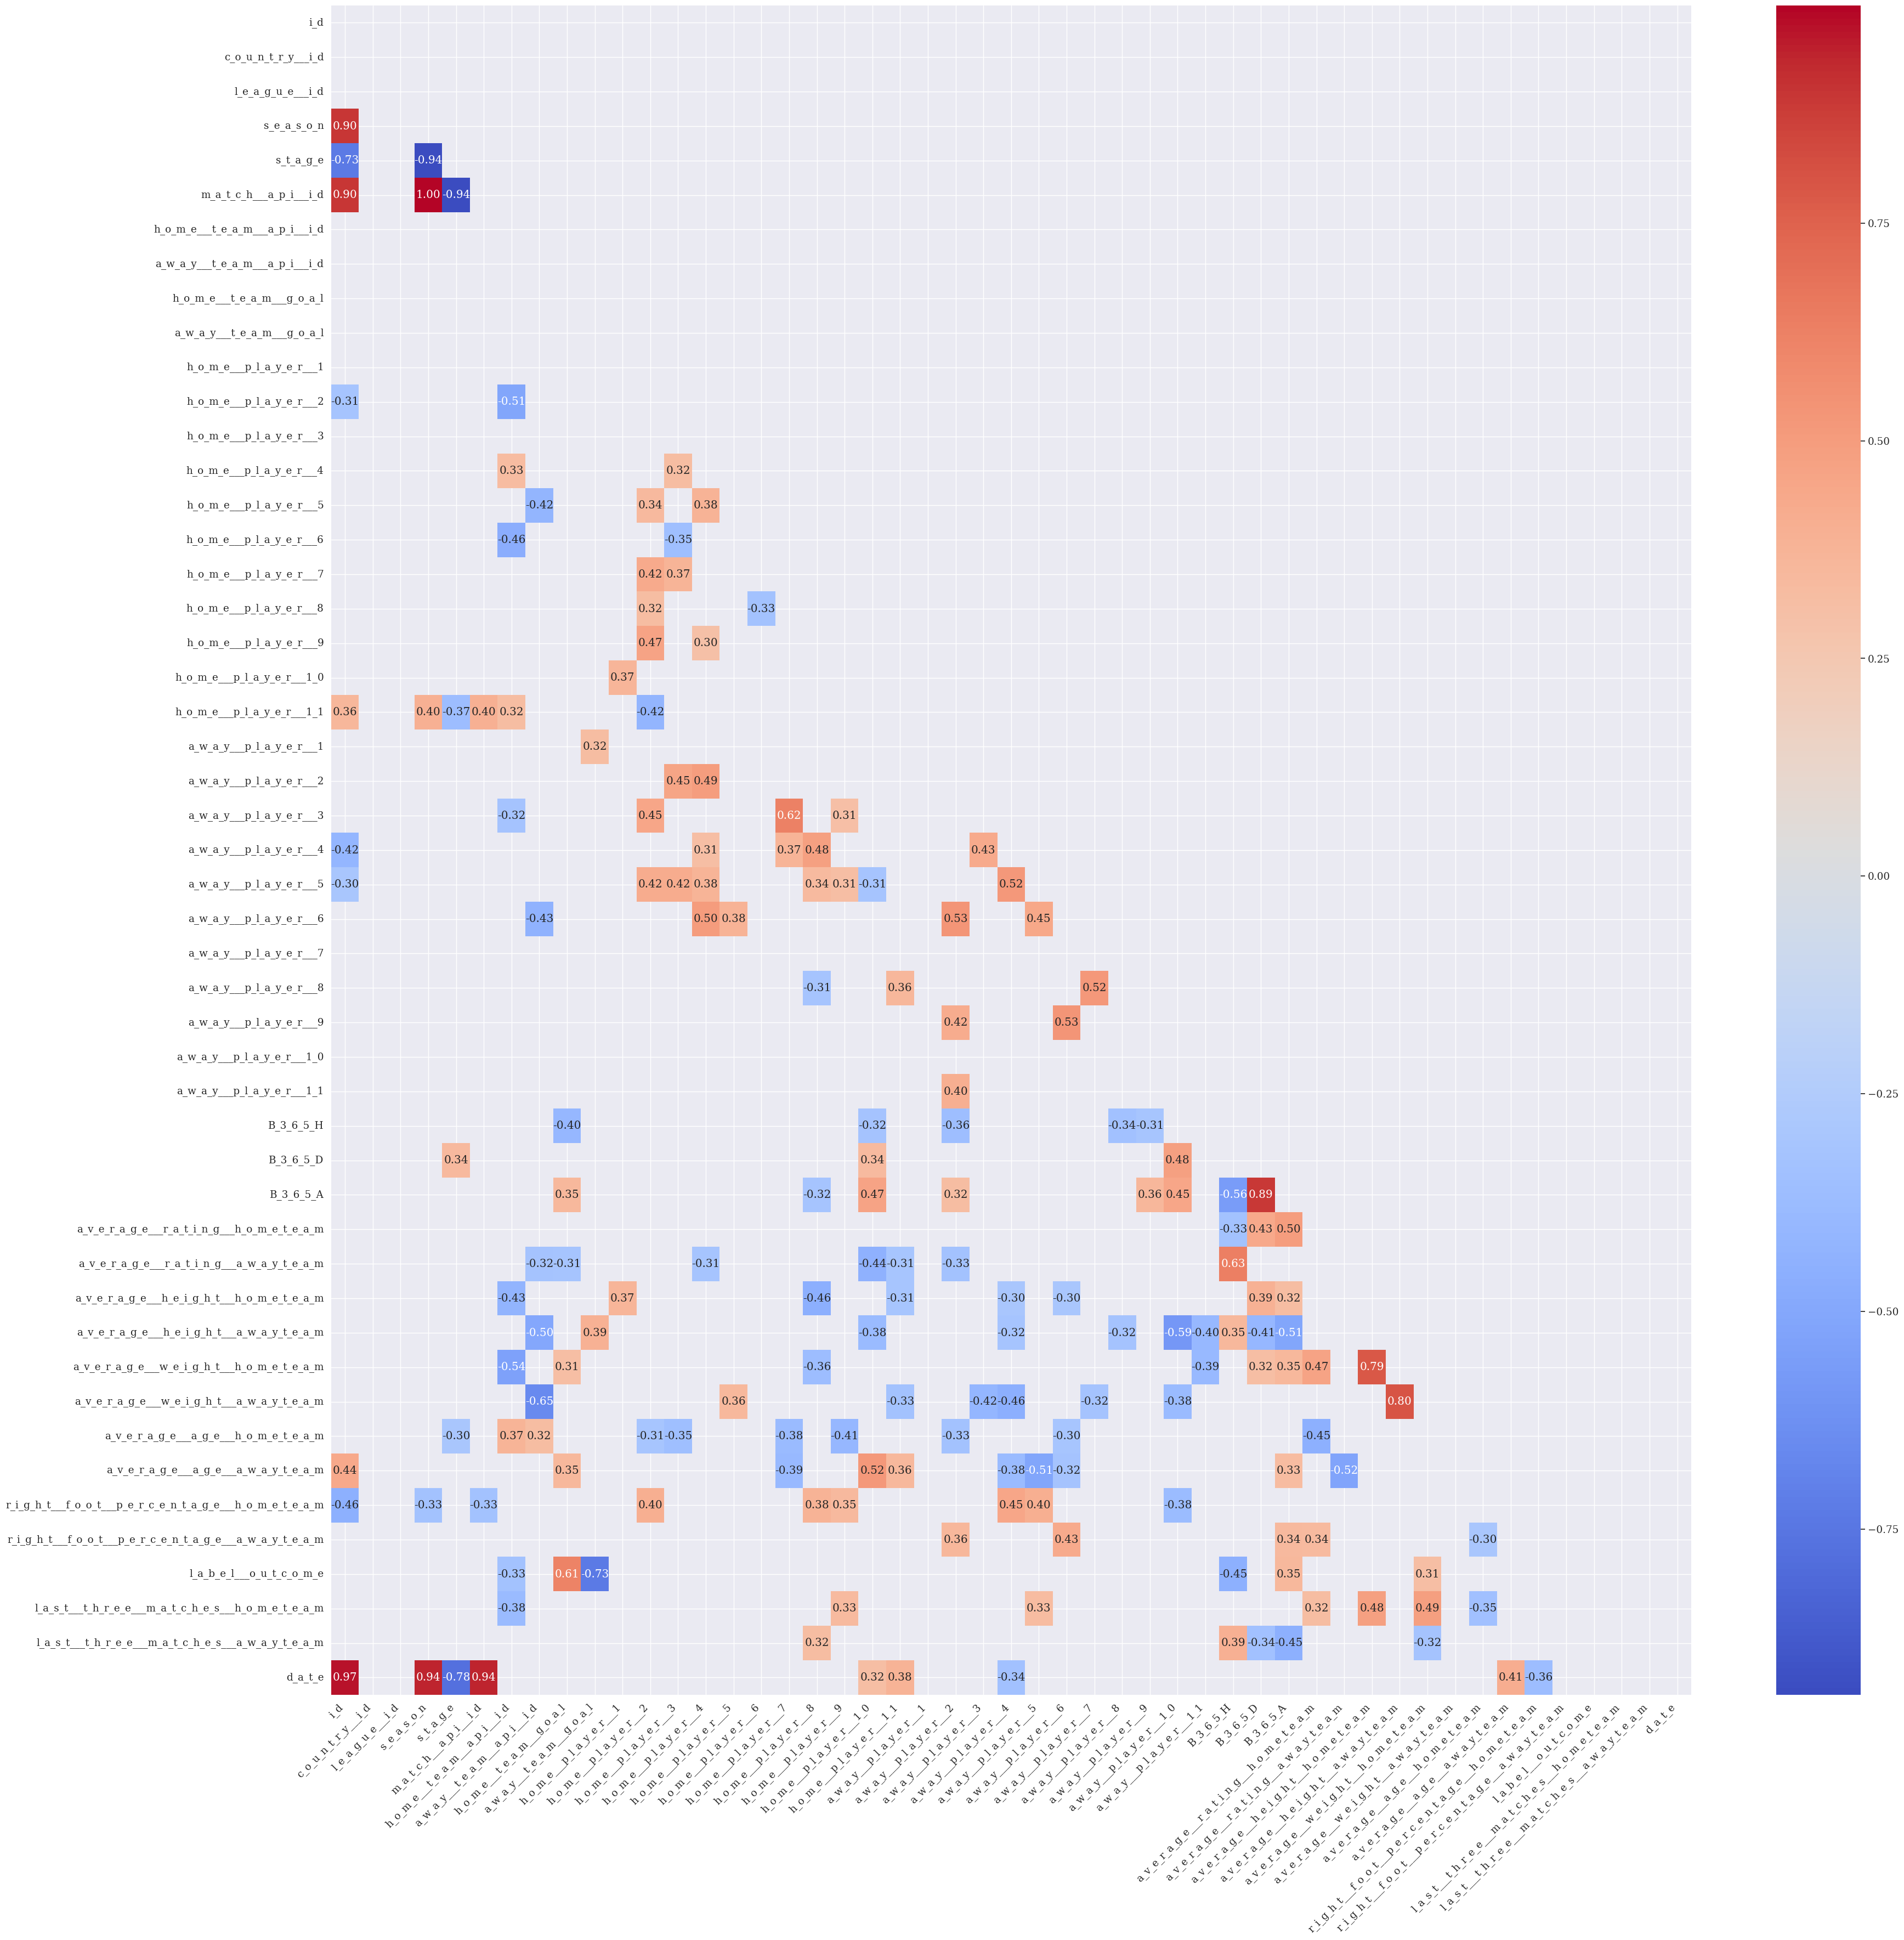

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create heatmap with custom threshold
plt.figure(figsize=(40, 40))
sns.heatmap(corr_matrix[(corr_matrix >= 0.3) | (corr_matrix <= -0.3)],
            cmap='coolwarm', annot=True, fmt='.2f', mask=mask)

# set the font color to black
sns.set(font_scale=1.2)
sns.set_style({'font.family': 'serif', 'fontcolor': 'black'})

plt.xticks(rotation=45, ha='right')
plt.show()


#Chi Squared

In [10]:
 # erstelle ein Dataframe für die Ergebnis von Chi2
chi2_results_df = pd.DataFrame(columns=['Column 1', 'Column 2', 'Chi-Squared', 'P-Value'])

# iteriert über jede Spalte des Dataframes
for col in df_dropped.columns:
    comparison_col = col

    # iteriert über jede Spalte des Dataframes
    for col in df_dropped.columns:

        # überspringt den Schritt, wenn die Spalten die gleichen sind
        if col == comparison_col:
            continue

        # erstellt eine Kontingenztabelle
        contingency_table = pd.crosstab(df_dropped[comparison_col], df_dropped[col])

        # führt chi2 aus und printed das Ergebnis
        chi2, pval, dof, expected = chi2_contingency(contingency_table)
                    #print(f\Chi-squared test for columns '{comparison_col}' and '{col}': chi2={chi2}, pval={pval}\)
        chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)

    print(chi2_results_df)

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

   Column 1                                           Column 2  Chi-Squared  \
0       i_d                                c_o_u_n_t_r_y___i_d          0.0   
1       i_d                                  l_e_a_g_u_e___i_d          0.0   
2       i_d                                        s_e_a_s_o_n         30.0   
3       i_d                                          s_t_a_g_e        360.0   
4       i_d                            m_a_t_c_h___a_p_i___i_d        870.0   
5       i_d                    h_o_m_e___t_e_a_m___a_p_i___i_d        360.0   
6       i_d                    a_w_a_y___t_e_a_m___a_p_i___i_d        330.0   
7       i_d                        h_o_m_e___t_e_a_m___g_o_a_l        120.0   
8       i_d                        a_w_a_y___t_e_a_m___g_o_a_l         90.0   
9       i_d                          h_o_m_e___p_l_a_y_e_r___1        450.0   
10      i_d                          h_o_m_e___p_l_a_y_e_r___2        600.0   
11      i_d                          h_o_m_e___p_l_a

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

               Column 1                                           Column 2  \
0                   i_d                                c_o_u_n_t_r_y___i_d   
1                   i_d                                  l_e_a_g_u_e___i_d   
2                   i_d                                        s_e_a_s_o_n   
3                   i_d                                          s_t_a_g_e   
4                   i_d                            m_a_t_c_h___a_p_i___i_d   
..                  ...                                                ...   
91  c_o_u_n_t_r_y___i_d  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
92  c_o_u_n_t_r_y___i_d                          l_a_b_e_l___o_u_t_c_o_m_e   
93  c_o_u_n_t_r_y___i_d  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
94  c_o_u_n_t_r_y___i_d  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
95  c_o_u_n_t_r_y___i_d                                            d_a_t_e   

    Chi-Squared   P-Value  
0           0.0  1.000000  
1      

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

              Column 1                                           Column 2  \
0                  i_d                                c_o_u_n_t_r_y___i_d   
1                  i_d                                  l_e_a_g_u_e___i_d   
2                  i_d                                        s_e_a_s_o_n   
3                  i_d                                          s_t_a_g_e   
4                  i_d                            m_a_t_c_h___a_p_i___i_d   
..                 ...                                                ...   
139  l_e_a_g_u_e___i_d  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
140  l_e_a_g_u_e___i_d                          l_a_b_e_l___o_u_t_c_o_m_e   
141  l_e_a_g_u_e___i_d  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
142  l_e_a_g_u_e___i_d  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
143  l_e_a_g_u_e___i_d                                            d_a_t_e   

     Chi-Squared   P-Value  
0            0.0  1.000000  
1            0.0 

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

        Column 1                                           Column 2  \
0            i_d                                c_o_u_n_t_r_y___i_d   
1            i_d                                  l_e_a_g_u_e___i_d   
2            i_d                                        s_e_a_s_o_n   
3            i_d                                          s_t_a_g_e   
4            i_d                            m_a_t_c_h___a_p_i___i_d   
..           ...                                                ...   
187  s_e_a_s_o_n  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
188  s_e_a_s_o_n                          l_a_b_e_l___o_u_t_c_o_m_e   
189  s_e_a_s_o_n  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
190  s_e_a_s_o_n  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
191  s_e_a_s_o_n                                            d_a_t_e   

     Chi-Squared   P-Value  
0       0.000000  1.000000  
1       0.000000  1.000000  
2      30.000000  0.414004  
3     360.000000  0.317417  
4 

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

      Column 1                                           Column 2  \
0          i_d                                c_o_u_n_t_r_y___i_d   
1          i_d                                  l_e_a_g_u_e___i_d   
2          i_d                                        s_e_a_s_o_n   
3          i_d                                          s_t_a_g_e   
4          i_d                            m_a_t_c_h___a_p_i___i_d   
..         ...                                                ...   
235  s_t_a_g_e  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
236  s_t_a_g_e                          l_a_b_e_l___o_u_t_c_o_m_e   
237  s_t_a_g_e  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
238  s_t_a_g_e  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
239  s_t_a_g_e                                            d_a_t_e   

     Chi-Squared       P-Value  
0       0.000000  1.000000e+00  
1       0.000000  1.000000e+00  
2      30.000000  4.140036e-01  
3     360.000000  3.174167e-01  
4     

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                    Column 1  \
0                        i_d   
1                        i_d   
2                        i_d   
3                        i_d   
4                        i_d   
..                       ...   
283  m_a_t_c_h___a_p_i___i_d   
284  m_a_t_c_h___a_p_i___i_d   
285  m_a_t_c_h___a_p_i___i_d   
286  m_a_t_c_h___a_p_i___i_d   
287  m_a_t_c_h___a_p_i___i_d   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d          0.0  1.000000  
1                                    l_e_a_g_u_e___i_d          0.0  1.000000  
2                                          s_e_a_s_o_n         30.0  0.414004  
3                                            s_t_a_g_e        360.0  0.317417  
4                              m_a_t_c_h___a_p_i___i_d        870.0  0.237197  
..                                                 ...          ...       ...  
283  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_... 

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                            Column 1  \
0                                i_d   
1                                i_d   
2                                i_d   
3                                i_d   
4                                i_d   
..                               ...   
331  h_o_m_e___t_e_a_m___a_p_i___i_d   
332  h_o_m_e___t_e_a_m___a_p_i___i_d   
333  h_o_m_e___t_e_a_m___a_p_i___i_d   
334  h_o_m_e___t_e_a_m___a_p_i___i_d   
335  h_o_m_e___t_e_a_m___a_p_i___i_d   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                     

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                            Column 1  \
0                                i_d   
1                                i_d   
2                                i_d   
3                                i_d   
4                                i_d   
..                               ...   
379  a_w_a_y___t_e_a_m___a_p_i___i_d   
380  a_w_a_y___t_e_a_m___a_p_i___i_d   
381  a_w_a_y___t_e_a_m___a_p_i___i_d   
382  a_w_a_y___t_e_a_m___a_p_i___i_d   
383  a_w_a_y___t_e_a_m___a_p_i___i_d   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                     

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                        Column 1  \
0                            i_d   
1                            i_d   
2                            i_d   
3                            i_d   
4                            i_d   
..                           ...   
427  h_o_m_e___t_e_a_m___g_o_a_l   
428  h_o_m_e___t_e_a_m___g_o_a_l   
429  h_o_m_e___t_e_a_m___g_o_a_l   
430  h_o_m_e___t_e_a_m___g_o_a_l   
431  h_o_m_e___t_e_a_m___g_o_a_l   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
427  r_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                        Column 1  \
0                            i_d   
1                            i_d   
2                            i_d   
3                            i_d   
4                            i_d   
..                           ...   
475  a_w_a_y___t_e_a_m___g_o_a_l   
476  a_w_a_y___t_e_a_m___g_o_a_l   
477  a_w_a_y___t_e_a_m___g_o_a_l   
478  a_w_a_y___t_e_a_m___g_o_a_l   
479  a_w_a_y___t_e_a_m___g_o_a_l   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
475  r_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
523  h_o_m_e___p_l_a_y_e_r___1   
524  h_o_m_e___p_l_a_y_e_r___1   
525  h_o_m_e___p_l_a_y_e_r___1   
526  h_o_m_e___p_l_a_y_e_r___1   
527  h_o_m_e___p_l_a_y_e_r___1   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
523  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
571  h_o_m_e___p_l_a_y_e_r___2   
572  h_o_m_e___p_l_a_y_e_r___2   
573  h_o_m_e___p_l_a_y_e_r___2   
574  h_o_m_e___p_l_a_y_e_r___2   
575  h_o_m_e___p_l_a_y_e_r___2   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
571  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
619  h_o_m_e___p_l_a_y_e_r___3   
620  h_o_m_e___p_l_a_y_e_r___3   
621  h_o_m_e___p_l_a_y_e_r___3   
622  h_o_m_e___p_l_a_y_e_r___3   
623  h_o_m_e___p_l_a_y_e_r___3   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
619  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
667  h_o_m_e___p_l_a_y_e_r___4   
668  h_o_m_e___p_l_a_y_e_r___4   
669  h_o_m_e___p_l_a_y_e_r___4   
670  h_o_m_e___p_l_a_y_e_r___4   
671  h_o_m_e___p_l_a_y_e_r___4   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
667  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
715  h_o_m_e___p_l_a_y_e_r___5   
716  h_o_m_e___p_l_a_y_e_r___5   
717  h_o_m_e___p_l_a_y_e_r___5   
718  h_o_m_e___p_l_a_y_e_r___5   
719  h_o_m_e___p_l_a_y_e_r___5   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
715  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
763  h_o_m_e___p_l_a_y_e_r___6   
764  h_o_m_e___p_l_a_y_e_r___6   
765  h_o_m_e___p_l_a_y_e_r___6   
766  h_o_m_e___p_l_a_y_e_r___6   
767  h_o_m_e___p_l_a_y_e_r___6   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
763  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
811  h_o_m_e___p_l_a_y_e_r___7   
812  h_o_m_e___p_l_a_y_e_r___7   
813  h_o_m_e___p_l_a_y_e_r___7   
814  h_o_m_e___p_l_a_y_e_r___7   
815  h_o_m_e___p_l_a_y_e_r___7   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
811  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
859  h_o_m_e___p_l_a_y_e_r___8   
860  h_o_m_e___p_l_a_y_e_r___8   
861  h_o_m_e___p_l_a_y_e_r___8   
862  h_o_m_e___p_l_a_y_e_r___8   
863  h_o_m_e___p_l_a_y_e_r___8   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
859  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                      Column 1  \
0                          i_d   
1                          i_d   
2                          i_d   
3                          i_d   
4                          i_d   
..                         ...   
907  h_o_m_e___p_l_a_y_e_r___9   
908  h_o_m_e___p_l_a_y_e_r___9   
909  h_o_m_e___p_l_a_y_e_r___9   
910  h_o_m_e___p_l_a_y_e_r___9   
911  h_o_m_e___p_l_a_y_e_r___9   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
907  r_i_g_h_t___f_o_o_t___p_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                        Column 1  \
0                            i_d   
1                            i_d   
2                            i_d   
3                            i_d   
4                            i_d   
..                           ...   
955  h_o_m_e___p_l_a_y_e_r___1_0   
956  h_o_m_e___p_l_a_y_e_r___1_0   
957  h_o_m_e___p_l_a_y_e_r___1_0   
958  h_o_m_e___p_l_a_y_e_r___1_0   
959  h_o_m_e___p_l_a_y_e_r___1_0   

                                              Column 2  Chi-Squared   P-Value  
0                                  c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                    l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                          s_e_a_s_o_n    30.000000  0.414004  
3                                            s_t_a_g_e   360.000000  0.317417  
4                              m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
..                                                 ...          ...       ...  
955  r_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                         Column 1  \
0                             i_d   
1                             i_d   
2                             i_d   
3                             i_d   
4                             i_d   
...                           ...   
1003  h_o_m_e___p_l_a_y_e_r___1_1   
1004  h_o_m_e___p_l_a_y_e_r___1_1   
1005  h_o_m_e___p_l_a_y_e_r___1_1   
1006  h_o_m_e___p_l_a_y_e_r___1_1   
1007  h_o_m_e___p_l_a_y_e_r___1_1   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ... 

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1051  a_w_a_y___p_l_a_y_e_r___1   
1052  a_w_a_y___p_l_a_y_e_r___1   
1053  a_w_a_y___p_l_a_y_e_r___1   
1054  a_w_a_y___p_l_a_y_e_r___1   
1055  a_w_a_y___p_l_a_y_e_r___1   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1051  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1099  a_w_a_y___p_l_a_y_e_r___2   
1100  a_w_a_y___p_l_a_y_e_r___2   
1101  a_w_a_y___p_l_a_y_e_r___2   
1102  a_w_a_y___p_l_a_y_e_r___2   
1103  a_w_a_y___p_l_a_y_e_r___2   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1099  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1147  a_w_a_y___p_l_a_y_e_r___3   
1148  a_w_a_y___p_l_a_y_e_r___3   
1149  a_w_a_y___p_l_a_y_e_r___3   
1150  a_w_a_y___p_l_a_y_e_r___3   
1151  a_w_a_y___p_l_a_y_e_r___3   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1147  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1195  a_w_a_y___p_l_a_y_e_r___4   
1196  a_w_a_y___p_l_a_y_e_r___4   
1197  a_w_a_y___p_l_a_y_e_r___4   
1198  a_w_a_y___p_l_a_y_e_r___4   
1199  a_w_a_y___p_l_a_y_e_r___4   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1195  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1243  a_w_a_y___p_l_a_y_e_r___5   
1244  a_w_a_y___p_l_a_y_e_r___5   
1245  a_w_a_y___p_l_a_y_e_r___5   
1246  a_w_a_y___p_l_a_y_e_r___5   
1247  a_w_a_y___p_l_a_y_e_r___5   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1243  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1291  a_w_a_y___p_l_a_y_e_r___6   
1292  a_w_a_y___p_l_a_y_e_r___6   
1293  a_w_a_y___p_l_a_y_e_r___6   
1294  a_w_a_y___p_l_a_y_e_r___6   
1295  a_w_a_y___p_l_a_y_e_r___6   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1291  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1339  a_w_a_y___p_l_a_y_e_r___7   
1340  a_w_a_y___p_l_a_y_e_r___7   
1341  a_w_a_y___p_l_a_y_e_r___7   
1342  a_w_a_y___p_l_a_y_e_r___7   
1343  a_w_a_y___p_l_a_y_e_r___7   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1339  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1387  a_w_a_y___p_l_a_y_e_r___8   
1388  a_w_a_y___p_l_a_y_e_r___8   
1389  a_w_a_y___p_l_a_y_e_r___8   
1390  a_w_a_y___p_l_a_y_e_r___8   
1391  a_w_a_y___p_l_a_y_e_r___8   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1387  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
1435  a_w_a_y___p_l_a_y_e_r___9   
1436  a_w_a_y___p_l_a_y_e_r___9   
1437  a_w_a_y___p_l_a_y_e_r___9   
1438  a_w_a_y___p_l_a_y_e_r___9   
1439  a_w_a_y___p_l_a_y_e_r___9   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
1435  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                         Column 1  \
0                             i_d   
1                             i_d   
2                             i_d   
3                             i_d   
4                             i_d   
...                           ...   
1483  a_w_a_y___p_l_a_y_e_r___1_0   
1484  a_w_a_y___p_l_a_y_e_r___1_0   
1485  a_w_a_y___p_l_a_y_e_r___1_0   
1486  a_w_a_y___p_l_a_y_e_r___1_0   
1487  a_w_a_y___p_l_a_y_e_r___1_0   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ... 

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                         Column 1  \
0                             i_d   
1                             i_d   
2                             i_d   
3                             i_d   
4                             i_d   
...                           ...   
1531  a_w_a_y___p_l_a_y_e_r___1_1   
1532  a_w_a_y___p_l_a_y_e_r___1_1   
1533  a_w_a_y___p_l_a_y_e_r___1_1   
1534  a_w_a_y___p_l_a_y_e_r___1_1   
1535  a_w_a_y___p_l_a_y_e_r___1_1   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ... 

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

       Column 1                                           Column 2  \
0           i_d                                c_o_u_n_t_r_y___i_d   
1           i_d                                  l_e_a_g_u_e___i_d   
2           i_d                                        s_e_a_s_o_n   
3           i_d                                          s_t_a_g_e   
4           i_d                            m_a_t_c_h___a_p_i___i_d   
...         ...                                                ...   
1579  B_3_6_5_H  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
1580  B_3_6_5_H                          l_a_b_e_l___o_u_t_c_o_m_e   
1581  B_3_6_5_H  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
1582  B_3_6_5_H  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
1583  B_3_6_5_H                                            d_a_t_e   

      Chi-Squared   P-Value  
0        0.000000  1.000000  
1        0.000000  1.000000  
2       30.000000  0.414004  
3      360.000000  0.317417  
4      87

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

       Column 1                                           Column 2  \
0           i_d                                c_o_u_n_t_r_y___i_d   
1           i_d                                  l_e_a_g_u_e___i_d   
2           i_d                                        s_e_a_s_o_n   
3           i_d                                          s_t_a_g_e   
4           i_d                            m_a_t_c_h___a_p_i___i_d   
...         ...                                                ...   
1627  B_3_6_5_D  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
1628  B_3_6_5_D                          l_a_b_e_l___o_u_t_c_o_m_e   
1629  B_3_6_5_D  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
1630  B_3_6_5_D  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
1631  B_3_6_5_D                                            d_a_t_e   

      Chi-Squared   P-Value  
0        0.000000  1.000000  
1        0.000000  1.000000  
2       30.000000  0.414004  
3      360.000000  0.317417  
4      87

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

       Column 1                                           Column 2  \
0           i_d                                c_o_u_n_t_r_y___i_d   
1           i_d                                  l_e_a_g_u_e___i_d   
2           i_d                                        s_e_a_s_o_n   
3           i_d                                          s_t_a_g_e   
4           i_d                            m_a_t_c_h___a_p_i___i_d   
...         ...                                                ...   
1675  B_3_6_5_A  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
1676  B_3_6_5_A                          l_a_b_e_l___o_u_t_c_o_m_e   
1677  B_3_6_5_A  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
1678  B_3_6_5_A  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
1679  B_3_6_5_A                                            d_a_t_e   

      Chi-Squared   P-Value  
0        0.000000  1.000000  
1        0.000000  1.000000  
2       30.000000  0.414004  
3      360.000000  0.317417  
4      87

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                           Column 1  \
0                                               i_d   
1                                               i_d   
2                                               i_d   
3                                               i_d   
4                                               i_d   
...                                             ...   
1723  a_v_e_r_a_g_e___r_a_t_i_n_g___h_o_m_e_t_e_a_m   
1724  a_v_e_r_a_g_e___r_a_t_i_n_g___h_o_m_e_t_e_a_m   
1725  a_v_e_r_a_g_e___r_a_t_i_n_g___h_o_m_e_t_e_a_m   
1726  a_v_e_r_a_g_e___r_a_t_i_n_g___h_o_m_e_t_e_a_m   
1727  a_v_e_r_a_g_e___r_a_t_i_n_g___h_o_m_e_t_e_a_m   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3              

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                           Column 1  \
0                                               i_d   
1                                               i_d   
2                                               i_d   
3                                               i_d   
4                                               i_d   
...                                             ...   
1771  a_v_e_r_a_g_e___r_a_t_i_n_g___a_w_a_y_t_e_a_m   
1772  a_v_e_r_a_g_e___r_a_t_i_n_g___a_w_a_y_t_e_a_m   
1773  a_v_e_r_a_g_e___r_a_t_i_n_g___a_w_a_y_t_e_a_m   
1774  a_v_e_r_a_g_e___r_a_t_i_n_g___a_w_a_y_t_e_a_m   
1775  a_v_e_r_a_g_e___r_a_t_i_n_g___a_w_a_y_t_e_a_m   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3              

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                           Column 1  \
0                                               i_d   
1                                               i_d   
2                                               i_d   
3                                               i_d   
4                                               i_d   
...                                             ...   
1819  a_v_e_r_a_g_e___h_e_i_g_h_t___h_o_m_e_t_e_a_m   
1820  a_v_e_r_a_g_e___h_e_i_g_h_t___h_o_m_e_t_e_a_m   
1821  a_v_e_r_a_g_e___h_e_i_g_h_t___h_o_m_e_t_e_a_m   
1822  a_v_e_r_a_g_e___h_e_i_g_h_t___h_o_m_e_t_e_a_m   
1823  a_v_e_r_a_g_e___h_e_i_g_h_t___h_o_m_e_t_e_a_m   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3              

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                           Column 1  \
0                                               i_d   
1                                               i_d   
2                                               i_d   
3                                               i_d   
4                                               i_d   
...                                             ...   
1867  a_v_e_r_a_g_e___h_e_i_g_h_t___a_w_a_y_t_e_a_m   
1868  a_v_e_r_a_g_e___h_e_i_g_h_t___a_w_a_y_t_e_a_m   
1869  a_v_e_r_a_g_e___h_e_i_g_h_t___a_w_a_y_t_e_a_m   
1870  a_v_e_r_a_g_e___h_e_i_g_h_t___a_w_a_y_t_e_a_m   
1871  a_v_e_r_a_g_e___h_e_i_g_h_t___a_w_a_y_t_e_a_m   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3              

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                           Column 1  \
0                                               i_d   
1                                               i_d   
2                                               i_d   
3                                               i_d   
4                                               i_d   
...                                             ...   
1915  a_v_e_r_a_g_e___w_e_i_g_h_t___h_o_m_e_t_e_a_m   
1916  a_v_e_r_a_g_e___w_e_i_g_h_t___h_o_m_e_t_e_a_m   
1917  a_v_e_r_a_g_e___w_e_i_g_h_t___h_o_m_e_t_e_a_m   
1918  a_v_e_r_a_g_e___w_e_i_g_h_t___h_o_m_e_t_e_a_m   
1919  a_v_e_r_a_g_e___w_e_i_g_h_t___h_o_m_e_t_e_a_m   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3              

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                           Column 1  \
0                                               i_d   
1                                               i_d   
2                                               i_d   
3                                               i_d   
4                                               i_d   
...                                             ...   
1963  a_v_e_r_a_g_e___w_e_i_g_h_t___a_w_a_y_t_e_a_m   
1964  a_v_e_r_a_g_e___w_e_i_g_h_t___a_w_a_y_t_e_a_m   
1965  a_v_e_r_a_g_e___w_e_i_g_h_t___a_w_a_y_t_e_a_m   
1966  a_v_e_r_a_g_e___w_e_i_g_h_t___a_w_a_y_t_e_a_m   
1967  a_v_e_r_a_g_e___w_e_i_g_h_t___a_w_a_y_t_e_a_m   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3              

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                     Column 1  \
0                                         i_d   
1                                         i_d   
2                                         i_d   
3                                         i_d   
4                                         i_d   
...                                       ...   
2011  a_v_e_r_a_g_e___a_g_e___h_o_m_e_t_e_a_m   
2012  a_v_e_r_a_g_e___a_g_e___h_o_m_e_t_e_a_m   
2013  a_v_e_r_a_g_e___a_g_e___h_o_m_e_t_e_a_m   
2014  a_v_e_r_a_g_e___a_g_e___h_o_m_e_t_e_a_m   
2015  a_v_e_r_a_g_e___a_g_e___h_o_m_e_t_e_a_m   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4     

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                     Column 1  \
0                                         i_d   
1                                         i_d   
2                                         i_d   
3                                         i_d   
4                                         i_d   
...                                       ...   
2059  a_v_e_r_a_g_e___a_g_e___a_w_a_y_t_e_a_m   
2060  a_v_e_r_a_g_e___a_g_e___a_w_a_y_t_e_a_m   
2061  a_v_e_r_a_g_e___a_g_e___a_w_a_y_t_e_a_m   
2062  a_v_e_r_a_g_e___a_g_e___a_w_a_y_t_e_a_m   
2063  a_v_e_r_a_g_e___a_g_e___a_w_a_y_t_e_a_m   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4     

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                               Column 1  \
0                                                   i_d   
1                                                   i_d   
2                                                   i_d   
3                                                   i_d   
4                                                   i_d   
...                                                 ...   
2107  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___h_...   
2108  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___h_...   
2109  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___h_...   
2110  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___h_...   
2111  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___h_...   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                               Column 1  \
0                                                   i_d   
1                                                   i_d   
2                                                   i_d   
3                                                   i_d   
4                                                   i_d   
...                                                 ...   
2155  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
2156  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
2157  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
2158  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   
2159  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                       Column 1  \
0                           i_d   
1                           i_d   
2                           i_d   
3                           i_d   
4                           i_d   
...                         ...   
2203  l_a_b_e_l___o_u_t_c_o_m_e   
2204  l_a_b_e_l___o_u_t_c_o_m_e   
2205  l_a_b_e_l___o_u_t_c_o_m_e   
2206  l_a_b_e_l___o_u_t_c_o_m_e   
2207  l_a_b_e_l___o_u_t_c_o_m_e   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_a_s_o_n    30.000000  0.414004  
3                                             s_t_a_g_e   360.000000  0.317417  
4                               m_a_t_c_h___a_p_i___i_d   870.000000  0.237197  
...                                                 ...          ...       ...  
2203  r_i_g_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                               Column 1  \
0                                                   i_d   
1                                                   i_d   
2                                                   i_d   
3                                                   i_d   
4                                                   i_d   
...                                                 ...   
2251  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
2252  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
2253  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
2254  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   
2255  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

                                               Column 1  \
0                                                   i_d   
1                                                   i_d   
2                                                   i_d   
3                                                   i_d   
4                                                   i_d   
...                                                 ...   
2299  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
2300  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
2301  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
2302  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   
2303  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   

                                               Column 2  Chi-Squared   P-Value  
0                                   c_o_u_n_t_r_y___i_d     0.000000  1.000000  
1                                     l_e_a_g_u_e___i_d     0.000000  1.000000  
2                                           s_e_

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

     Column 1                                           Column 2  Chi-Squared  \
0         i_d                                c_o_u_n_t_r_y___i_d     0.000000   
1         i_d                                  l_e_a_g_u_e___i_d     0.000000   
2         i_d                                        s_e_a_s_o_n    30.000000   
3         i_d                                          s_t_a_g_e   360.000000   
4         i_d                            m_a_t_c_h___a_p_i___i_d   870.000000   
...       ...                                                ...          ...   
2347  d_a_t_e  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___h_...   249.107143   
2348  d_a_t_e  r_i_g_h_t___f_o_o_t___p_e_r_c_e_n_t_a_g_e___a_...   157.833333   
2349  d_a_t_e                          l_a_b_e_l___o_u_t_c_o_m_e    41.658730   
2350  d_a_t_e  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___h_o_m_e_...   112.035714   
2351  d_a_t_e  l_a_s_t___t_h_r_e_e___m_a_t_c_h_e_s___a_w_a_y_...   168.809524   

       P-Value  
0     1.00

C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared': chi2, 'P-Value': pval}, ignore_index=True)
C:\Users\maikk\AppData\Local\Temp\ipykernel_11708\3225418109.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  chi2_results_df = chi2_results_df.append({'Column 1': comparison_col, 'Column 2': col, 'Chi-Squared':

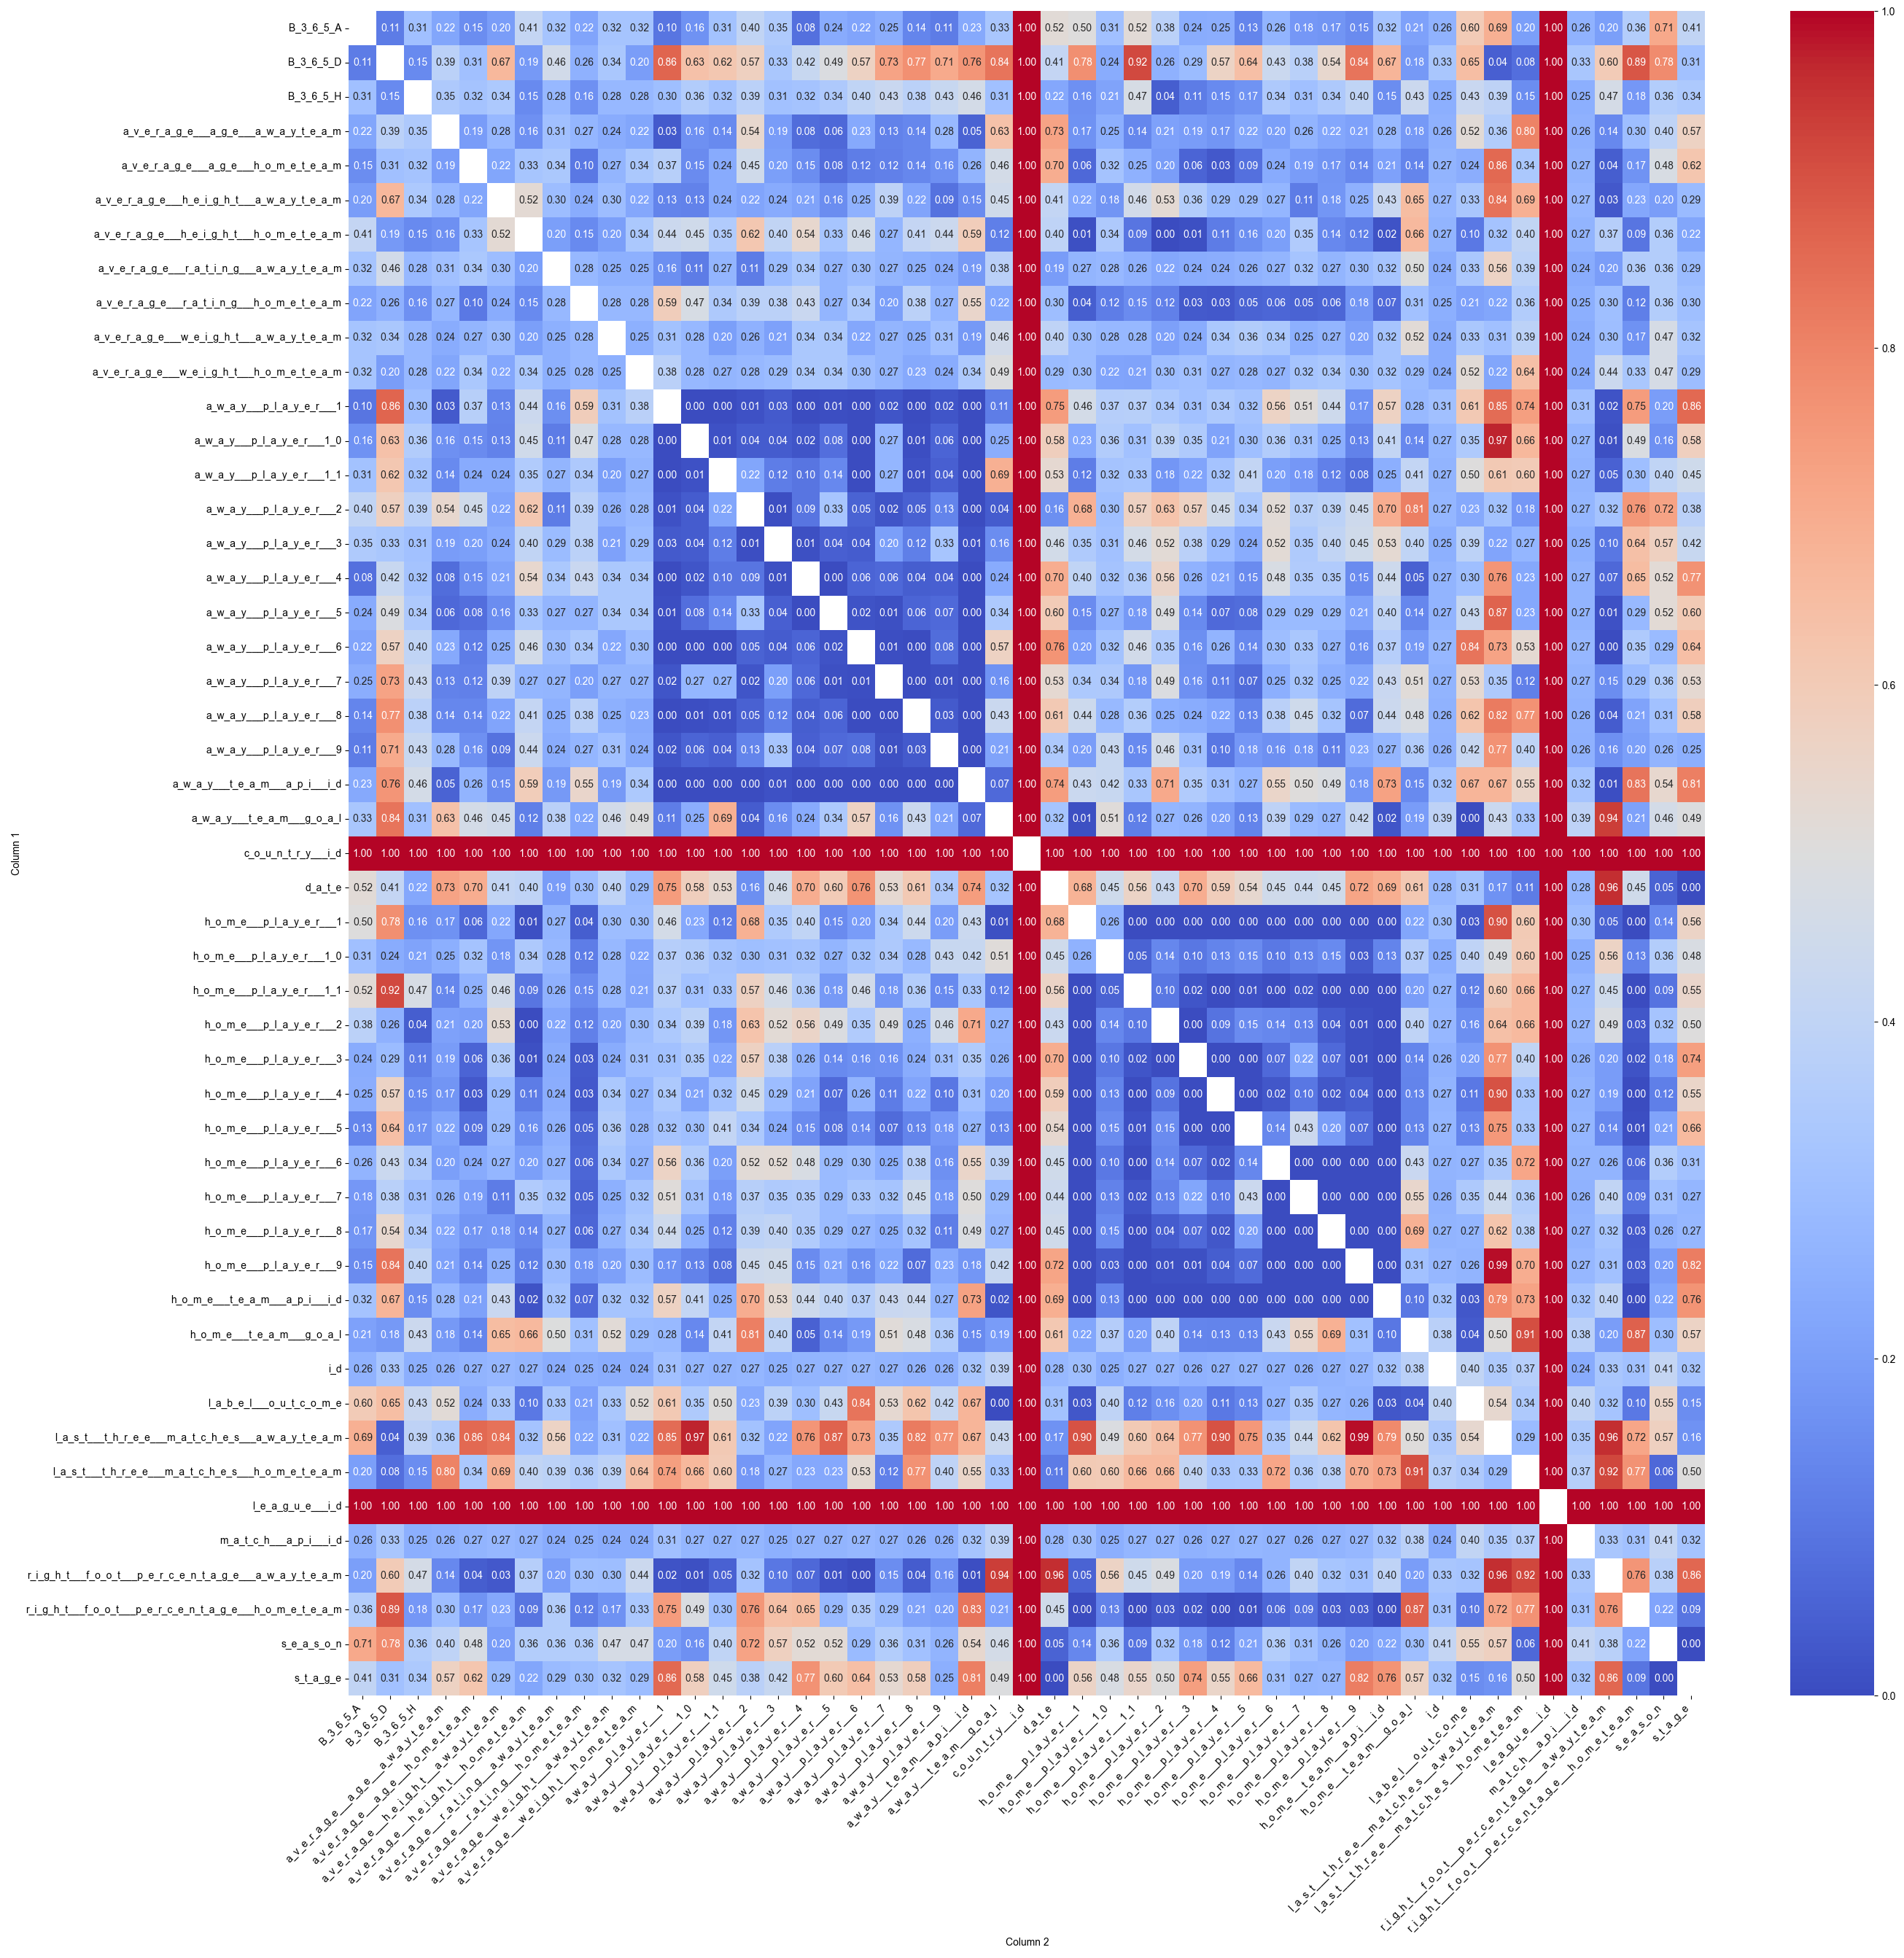

In [21]:
import numpy as np
import seaborn as sns

# pivot the chi2_results_df to make a matrix
heatmap_data = chi2_results_df.pivot(index='Column 1', columns='Column 2', values='P-Value')


plt.figure(figsize=(30, 30))

# create a heatmap
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f')

# set the font color to black
sns.set(font_scale=1.2)
sns.set_style({'font.family': 'serif', 'fontcolor': 'black'})

plt.xticks(rotation=45, ha='right')
plt.show()


# Spalten mit hoher Korrelation löschen

In [ ]:
df_dropped = df_dropped.drop('id', axis=1)
df_dropped = df_dropped.drop('country_id', axis=1)
df_dropped = df_dropped.drop('league_id', axis=1)
df_dropped = df_dropped.drop('season', axis=1)
df_dropped = df_dropped.drop('home_team_goal', axis=1)
df_dropped = df_dropped.drop('away_team_goal', axis=1)

# Convert every non numeric column to a numeric column

In [ ]:
df_dropped['date_int'] = df_dropped['date'].apply(lambda x: int(x.replace('-', '').replace(' ', '').replace(':', '')))
df_dropped = df_dropped.drop('date', axis=1)
df_dropped = df_dropped.rename(columns={'date_int': 'date'})

# create dictionary to map outcome labels to integer values
outcome_map = {'Win': 1, 'Lose': -1, 'Draw': 0}

# convert outcome labels to integer values
df_dropped['label_outcome_int'] = df_dropped['label_outcome'].map(outcome_map)

# replace original column with new integer column
df_dropped['label_outcome'] = df_dropped['label_outcome_int']

# drop temporary integer column
df_dropped = df_dropped.drop('label_outcome_int', axis=1)


#df_dropped['season'] = df_dropped['season'].str.split('/').str[0].astype(int)

df_dropped.describe()
df_dropped["date"] = df_dropped["date"].astype(int)
df_dropped["label_outcome"] = df_dropped["label_outcome"].astype(int)

print(df_dropped.dtypes)



In [ ]:

df_temp = df_dropped
conn = sqlite3.connect('neue_datenbank_numeric.db')
df_temp.to_sql('neue_tabelle_mit_500_numerischen_Daten', conn, if_exists='replace', index=False)
conn.close()



In [27]:
# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect('neue_datenbank_numeric.db')

# SQL-Abfrage ausführen und Ergebnis in ein Pandas-Dataframe laden
df = pd.read_sql("SELECT * FROM neue_tabelle_mit_500_numerischen_Daten", conn)

# Verbindung schließen
conn.close()

df_dropped = df

In [28]:

# Trennung von Features und Zielvariablen
features = df_dropped.drop('label_outcome', axis=1)
target = df_dropped['label_outcome']


# Definition des Modells
model = LinearRegression()

# Erstellung des RFE-Objekts mit 10 gewünschten Features
rfe = RFE(model, n_features_to_select=10)

# Anpassung des RFE-Objekts an die Daten
rfe.fit(features, target)

# Ausgabe der ausgewählten Features
selected_features = features.columns[rfe.support_]
print(selected_features)

Index(['home_team_goal', 'away_team_goal', 'average_rating_hometeam',
       'average_height_awayteam', 'average_weight_hometeam',
       'average_weight_awayteam', 'average_age_hometeam',
       'right_foot_percentage_hometeam', 'right_foot_percentage_awayteam',
       'last_three_matches_hometeam'],
      dtype='object')


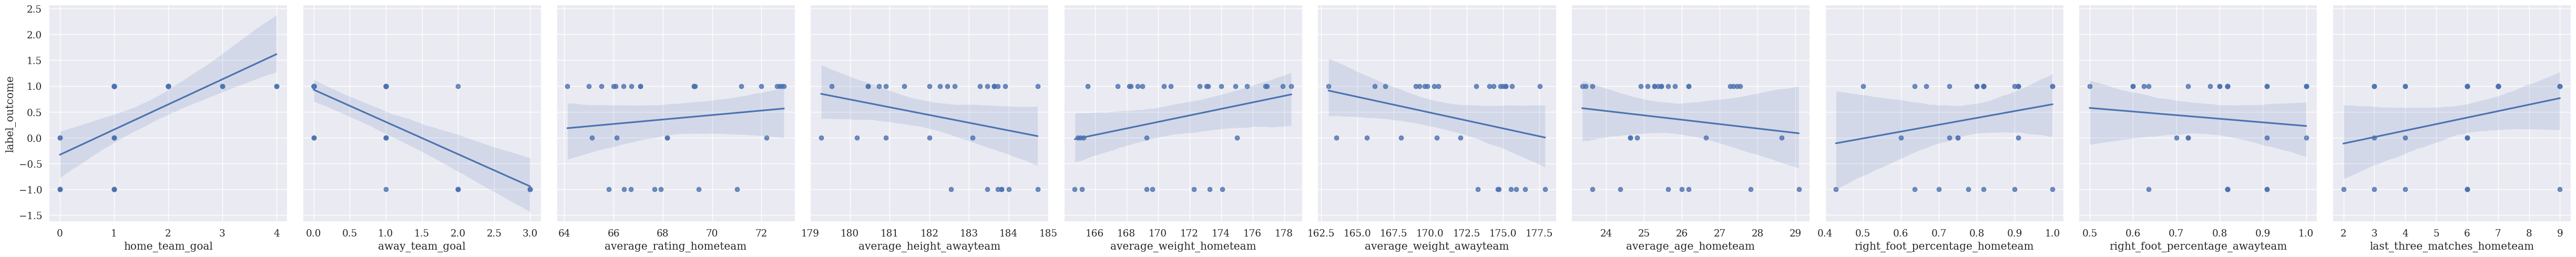

In [29]:
import seaborn as sns

# assuming you have split your data into features and target
# and have selected the desired features for the model
# you can create a dataframe with the selected features and the target variable
data = pd.concat([features[selected_features], target], axis=1)

# create a pairplot to visualize the relationships between the variables
sns.pairplot(data, x_vars=selected_features, y_vars='label_outcome', height=5, aspect=1, kind='reg')


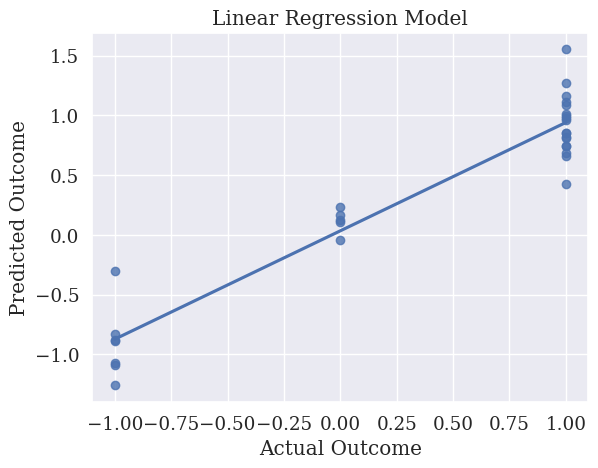

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Fit the linear regression model
model.fit(features[selected_features], target)

# Make predictions
y_pred = model.predict(features[selected_features])

# Create a regression plot
sns.regplot(x=target, y=y_pred, ci=None)

# Set the axis labels and title
plt.xlabel('Actual Outcome')
plt.ylabel('Predicted Outcome')
plt.title('Linear Regression Model')

# Show the plot
plt.show()


#Random Forest

In [61]:
# Entfernen von Zeilen, die NaN-Werte in der Zielvariablen enthalten
from sklearn.impute import SimpleImputer


# Trennung von Features und Zielvariablen
features = df_dropped.drop('label_outcome', axis=1)
target = df_dropped['label_outcome']

# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Imputation fehlender Werte mit dem Durchschnitt
imputer = SimpleImputer(strategy='mean')
features_train = imputer.fit_transform(features_train)
features_test = imputer.transform(features_test)

# Definition des Random-Forest-Modells
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training des Modells auf den Trainingsdaten
rf.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = rf.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Genauigkeit: {accuracy}")


Genauigkeit: 0.5


In [62]:
# Trennung von Features und Zielvariablen
features = df_dropped.drop('label_outcome', axis=1)
target = df_dropped['label_outcome']

# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

from sklearn.impute import SimpleImputer
# replace missing values with the mean of the feature values
imputer = SimpleImputer(strategy='mean')
features_train = imputer.fit_transform(features_train)
features_test = imputer.transform(features_test)


# Definition des Random-Forest-Modells
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Training des Modells auf den Trainingsdaten
rf.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = rf.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Genauigkeit: {accuracy}")

Genauigkeit: 0.5


#Logistische Regression

In [1]:
# Trennung von Features und Zielvariablen
features = df_dropped.drop('label_outcome', axis=1)
target = df_dropped['label_outcome']

# Aufteilen der Daten in Trainings- und Testdaten
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Definition des logistischen Regressionsmodells
lr = LogisticRegression()

# Training des Modells auf den Trainingsdaten
lr.fit(features_train, target_train)

# Vorhersage auf den Testdaten
target_pred = lr.predict(features_test)

# Berechnung der Genauigkeit
accuracy = accuracy_score(target_test, target_pred)
print(f"Genauigkeit: {accuracy}")

NameError: name 'df_dropped' is not defined